In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import autokeras as ak
from numpy import random
import time

In [2]:
#Plot's Making  Packages
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib.collections import LineCollection
from matplotlib import cm

%config InlineBackend. figure_format = 'retina'

In [6]:
model_theta23 = tf.keras.models.load_model('/work/ML4NO/ML/Regression/models_furthurTrain/0804_theta23_1.h5')
model_theta23.summary()
model_delta = tf.keras.models.load_model('/work/ML4NO/ML/Regression/models_furthurTrain/0804_delta_1.h5')
model_delta.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 244)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 244)               0         
_________________________________________________________________
normalization (Normalization (None, 244)               489       
_________________________________________________________________
dense (Dense)                (None, 1024)              250880    
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)               

In [7]:
cut_index = np.load('/work/NIO_largerthan1000_index.npy')
data_IO = np.load('/work/NuFit_IO.npz')
data_NO = np.load('/work/NuFit_NO.npz')

In [8]:
data_IO_mid = np.column_stack([data_IO['ve_dune'], data_IO['vu_dune'], data_IO['vebar_dune'], data_IO['vubar_dune'], data_IO['ve_t2hk'], data_IO['vu_t2hk'], data_IO['vebar_t2hk'], data_IO['vubar_t2hk']])[0]
data_NO_mid = np.column_stack([data_NO['ve_dune'], data_NO['vu_dune'], data_NO['vebar_dune'], data_NO['vubar_dune'], data_NO['ve_t2hk'], data_NO['vu_t2hk'], data_NO['vebar_t2hk'], data_NO['vubar_t2hk']])[0]

data_IO_mid = data_IO_mid
data_NO_mid = data_NO_mid

In [21]:
%%time
N = 1000000
statistics_state = 1 

if statistics_state == 0:
    std = 0.01
    data_create_IO = random.normal(data_IO_mid, std*sqrt(data_IO_mid), size = (N, len(data_IO_mid)))
    data_create_NO = random.normal(data_NO_mid, std*sqrt(data_NO_mid), size = (N, len(data_IO_mid)))
elif statistics_state == 1:
    data_create_IO = random.poisson(data_IO_mid, size = (N, len(data_IO_mid)))
    data_create_NO = random.poisson(data_NO_mid, size = (N, len(data_NO_mid)))

CPU times: user 1min 1s, sys: 881 ms, total: 1min 2s
Wall time: 1min 2s


In [22]:
%%time
pre_create_IO_theta23 = model_theta23.predict(data_create_IO)
pre_create_IO_delta = model_delta.predict(data_create_IO)
pre_create_NO_theta23 = model_theta23.predict(data_create_NO)
pre_create_NO_delta = model_delta.predict(data_create_NO)

In [221]:
%%time

IO_or_NO = 1 # 0 for IO and 1 for NO

if IO_or_NO == 0:
    input_theta23 = pre_create_IO_theta23
    input_delta = pre_create_IO_delta
else:
    input_theta23 = pre_create_NO_theta23
    input_delta = pre_create_NO_delta

bins_theta23 = np.linspace(min(input_theta23[:,0]), max(input_theta23[:,0]), 100)
bins_delta = np.linspace(min(input_delta[:,0]), max(input_delta[:,0]), 100)
likeliregion, xedges, yedges = np.histogram2d(input_theta23[:,0], input_delta[:,0], bins = [bins_theta23,bins_delta])

likeliregion = likeliregion.T

max_poi = np.where(likeliregion == likeliregion.max())
print(max_poi)
print("Maximum: theta23 {}, delta {} ".format(xedges[max_poi[0]],yedges[max_poi[1]]))
print("Maximum: theta23 {}, delta {} ".format(xedges[max_poi[1]],yedges[max_poi[0]]))
sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]

tot_event_num = sorted_list.sum()

onesigma = 0
for i in range(len(sorted_list)):
    onesigma += sorted_list[i]
    if onesigma/tot_event_num >= 0.68:
        one_sigma_poi = i
        break
        
twosigma = 0
for i in range(len(sorted_list)):
    twosigma += sorted_list[i]        
    if twosigma/tot_event_num >= 0.95:
        two_sigma_poi = i
        break

print("one_sigma_poi ", one_sigma_poi)
one_sigma_region = np.where(likeliregion < sorted_list[one_sigma_poi], 0, likeliregion )
one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region )
one_sigma_allowed_region = np.where(one_sigma_region_boundary != 0)

print("two_sigma_poi ", two_sigma_poi)
two_sigma_region = np.where(likeliregion < sorted_list[two_sigma_poi], 0, likeliregion )
two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region )
two_sigma_allowed_region = np.where(two_sigma_region_boundary != 0)

(array([26]), array([47]))
Maximum: theta23 [48.3313967], delta [217.36077603] 
Maximum: theta23 [49.15591693], delta [194.44032426] 
one_sigma_poi  388
two_sigma_poi  1056
CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.07 s


In [222]:
X, Y = np.meshgrid(yedges, xedges)
print(X[47,26])
print(Y[47,26])
print(X[26,47])
print(Y[26,47])

194.4403242631392
49.155916926836724
217.36077603426847
48.33139670015586


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys


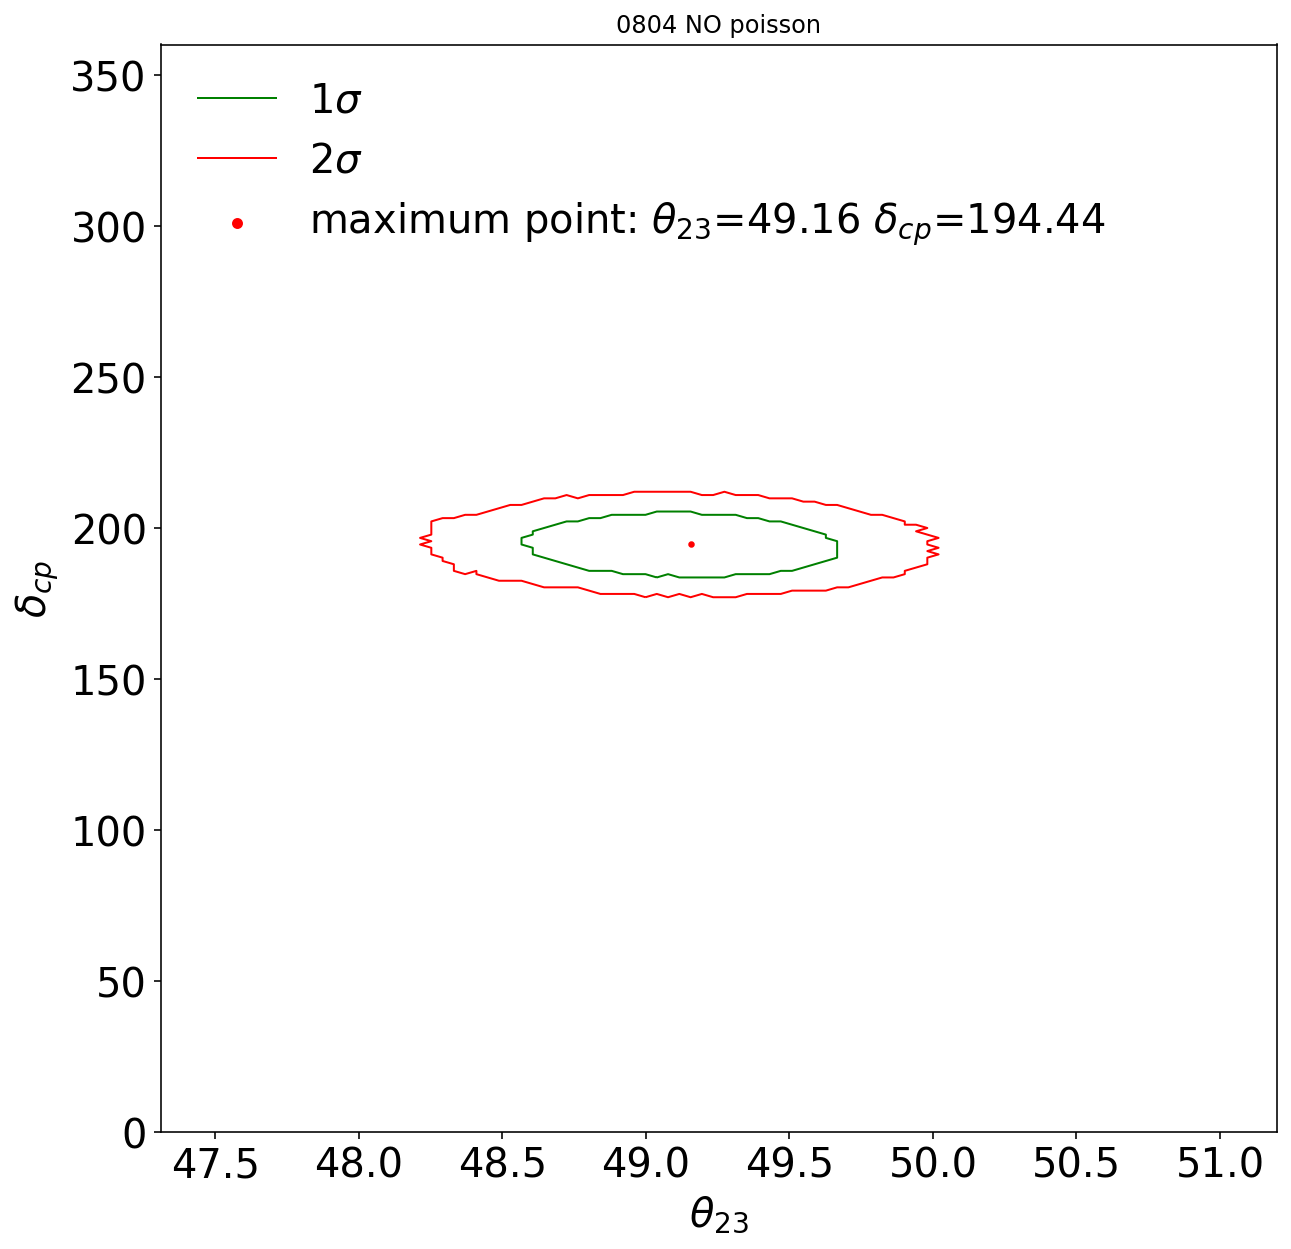

CPU times: user 924 ms, sys: 14.1 ms, total: 938 ms
Wall time: 930 ms


In [224]:
%%time
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.xlim((min(input_theta23[:,0]), max(input_theta23[:,0])))    
plt.ylim((0, 360))

X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
CS_1_sigma = plt.contour(X, Y, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(X, Y, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
plt.scatter(xedges[max_poi[1]],yedges[max_poi[0]], c="r", s=5, label = "maximum point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]][0]))


CS_1_sigma.collections[0].set_label("1$\sigma$")
CS_2_sigma.collections[0].set_label("2$\sigma$")

ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.legend(loc="upper left", ncol=1, fontsize=20, markerscale=2., scatterpoints=1,
           edgecolor = "w",fancybox=False, framealpha=0)
plt.xlabel('$\\theta_{23}$', fontsize=20)
plt.ylabel('$\delta_{cp}$', fontsize=20)
if IO_or_NO == 0:
    if statistics_state == 0: plt.title('0804 IO gaussian, std = {}'.format(std))
    if statistics_state == 1: plt.title('0804 IO poisson')
else: 
    if statistics_state == 0: plt.title('0804 NO gaussian, std = {}'.format(std))
    if statistics_state == 1: plt.title('0804 NO poisson')
plt.show()

In [225]:
# -*- coding: utf-8 -*-
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from scipy import interpolate
import matplotlib.cm as cm
import matplotlib.pyplot as plt
 
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

In [226]:
#總資料組數
N_DUNE = 92
N_T2HK = 36
N_DUT2 = 96

In [227]:
theta23_DUNE = []
delta_cp_DUNE = []
chi_DUNE = []
theta23_T2HK = []
delta_cp_T2HK = []
chi_T2HK = []
theta23_DUT2 = []
delta_cp_DUT2 = []
chi_DUT2 = []

In [240]:
#Import txt檔
f_DUNE = open("/work/chi_square-4-2_figB_DUNE.txt")
f_T2HK = open("/work/chi_square-4-2_figB_T2HK.txt")
f_DUT2 = open("/work/chi_square-4-2_figB_DUT2.txt")

In [229]:
for i in range(N_DUNE):
    s = f_DUNE.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUNE.append(array[0])
    delta_cp_DUNE.append(array[1]) 
    chi_DUNE.append(array[2])
for i in range(N_T2HK):
    s = f_T2HK.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_T2HK.append(array[0])
    delta_cp_T2HK.append(array[1]) 
    chi_T2HK.append(array[2])
for i in range(N_DUT2):
    s = f_DUT2.readline().split()
    array = []
    for j in range(len(s)) :
        array.append(float(s[j])) 
    theta23_DUT2.append(array[0])
    delta_cp_DUT2.append(array[1]) 
    chi_DUT2.append(array[2])

In [230]:
theta23_DUNE = np.array(theta23_DUNE)
delta_cp_DUNE = np.array(delta_cp_DUNE)
chi_DUNE = np.array(chi_DUNE)
theta23_T2HK = np.array(theta23_T2HK)
delta_cp_T2HK = np.array(delta_cp_T2HK)
chi_T2HK = np.array(chi_T2HK)
theta23_DUT2 = np.array(theta23_DUT2)
delta_cp_DUT2 = np.array(delta_cp_DUT2)
chi_DUT2 = np.array(chi_DUT2)

In [231]:
x0 = np.linspace(min(theta23_DUNE)*10-30, max(theta23_DUNE)*10 + 30, 68)/10
y0 = np.linspace(min(delta_cp_DUNE)-6, max(delta_cp_DUNE)+6, 20)
X0, Y0 = np.meshgrid(x0, y0)
Z0 = np.zeros((len(X0),len(X0[0])))

for i in range(len(theta23_DUNE)):
    a = np.where(X0 == theta23_DUNE[i])[1][0]
    b = np.where(Y0 == delta_cp_DUNE[i])[0][0]
    Z0[b][a] = 1

In [232]:
x1 = np.linspace(min(theta23_T2HK)*10-30, max(theta23_T2HK)*10 + 30, 65)/10
y1 = np.linspace(min(delta_cp_T2HK)-6, max(delta_cp_T2HK)+6, 14)
X1, Y1 = np.meshgrid(x1, y1)
Z1 = np.zeros((len(X1),len(X1[0])))

for i in range(len(theta23_T2HK)):
    a = np.where(X1 == theta23_T2HK[i])[1][0]
    b = np.where(Y1 == delta_cp_T2HK[i])[0][0]
    Z1[b][a] = 1

In [233]:
x2 = np.linspace(min(theta23_DUT2)*10-30, max(theta23_DUT2)*10 + 30, 129)/10
y2 = np.linspace(min(delta_cp_DUT2)-6, max(delta_cp_DUT2)+6, 25)
X2, Y2 = np.meshgrid(x2, y2)
Z2 = np.zeros((len(X2),len(X2[0])))

for i in range(len(theta23_DUT2)):
    a = np.where(X2 == theta23_DUT2[i])[1][0]
    b = np.where(Y2 == delta_cp_DUT2[i])[0][0]
    Z2[b][a] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: No contour levels were found within the data range.
  if sys.path[0] == '':


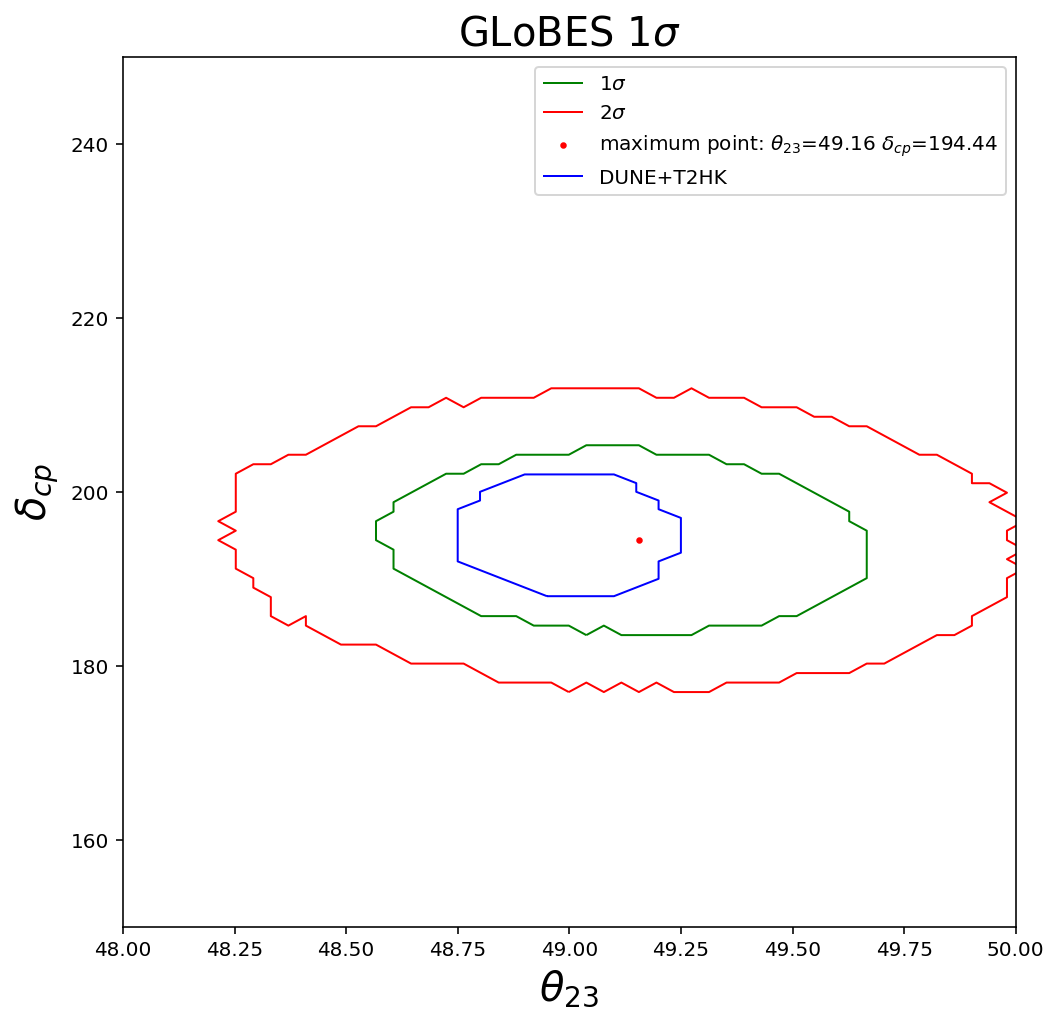

In [238]:
from matplotlib.collections import LineCollection
plt.figure(figsize = (8,8))
plt.xlim(48, 50)
plt.ylim(150, 250)

CS_1_sigma = plt.contour(X, Y, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
CS_2_sigma = plt.contour(X, Y, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
CS_1_sigma.collections[0].set_label("1$\sigma$")
CS_2_sigma.collections[0].set_label("2$\sigma$")
plt.scatter(xedges[max_poi[1]],yedges[max_poi[0]], c="r", s=5, label = "maximum point: $\\theta_{23}$=%.2f $\delta_{cp}$=%.2f" %(xedges[max_poi[1]][0], yedges[max_poi[0]][0]))

DUT2 = plt.contour(X2, Y2, Z2, 0, colors='blue', linestyles="-", linewidths=1)
DUT2.collections[0].set_label("DUNE+T2HK")
plt.xlabel(r'$\theta_{23} $', fontsize=20)
plt.ylabel(r'$\delta_{cp} $', fontsize=20)
plt.title('GLoBES 'r'$1\sigma $', fontsize=20)
plt.legend()